<a href="https://colab.research.google.com/github/pgurazada/share-of-shelf-with-multimodal-models/blob/main/share_of_shelf_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Large Multimodal Models</center></font></h1>
<h1><center>Share of Shelf Computation</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

# Objective

To showcase how Large Multimodal Models (LMMs) can be used for business tasks.

# Background



## Why are LMMs exciting?

In recent times, Large Language Models (LLMs) have revolutionalized the way business extract value out of unstructured data. However, LLMs are text-input only limiting their applicability to situations where the input is documents (e.g., pdfs, txt, ppt). How about we extend the input modalities beyond text? This is the promise of Large Multimodal Models - the ability to integrate information from diverse sources such as text, image, audio, and video.

Operating on information fused from multiple sources LMMs promise to pack a significant punch. Since they have richer and more complete understanding of the underlying data, this is bound to unlock new insights and enable a wide range of applications.
For example, improved speech recognition accuracy by combining audio and visual data, such as analyzing both the audio signal of speech and corresponding lip movements. As another example, in medicine, multimodal fusion can combine information from multiple modes for tasks such as diagnosis and treatment planning.




## What are LMMs?

Large Multimodal Models are trained on multimodal datasets where each sample is a combination of two or more of the following modalities: images, audio and text. These models fuse information from these different modalities into a joint representation that is then used as an input to a model. A key breakthrough achieved in the second half of 2023 was [visual instruction tuning](https://arxiv.org/abs/2304.08485). Armed with visual instruction tuning data (see figure below) it is now possible to present an image/video/audio and additional context to a model and interact with it using natural language instructions (just like GPT).



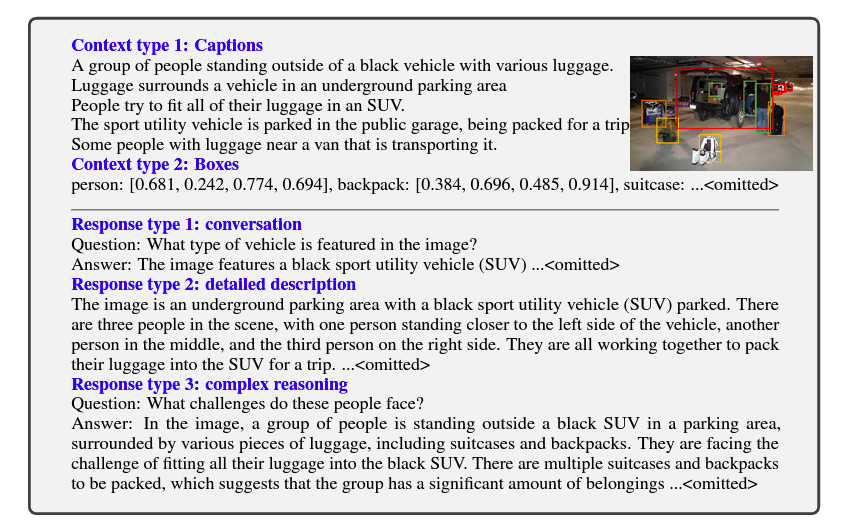

[Source](https://arxiv.org/pdf/2304.08485.pdf)

Popular LMMs include:
- [LLaVa](https://huggingface.co/spaces/badayvedat/LLaVA)
- [GPT4](https://openai.com/gpt-4)
- [Gemini Pro Vision](https://blog.google/technology/ai/gemini-api-developers-cloud/)

Of these models, Gemini Pro Vision claims to be the only model that was built to be [multimodal ground up with superior reasoning skills](https://developers.googleblog.com/2023/12/how-its-made-gemini-multimodal-prompting.html).

In this notebook, we put Gemini Pro Vision to the test with a difficult business use case.

# Business Problem

Imagine that you are a large FMCG brand that relies on appropriate stock levels on retail shelves for sales. A typical retail shelf looks like so:

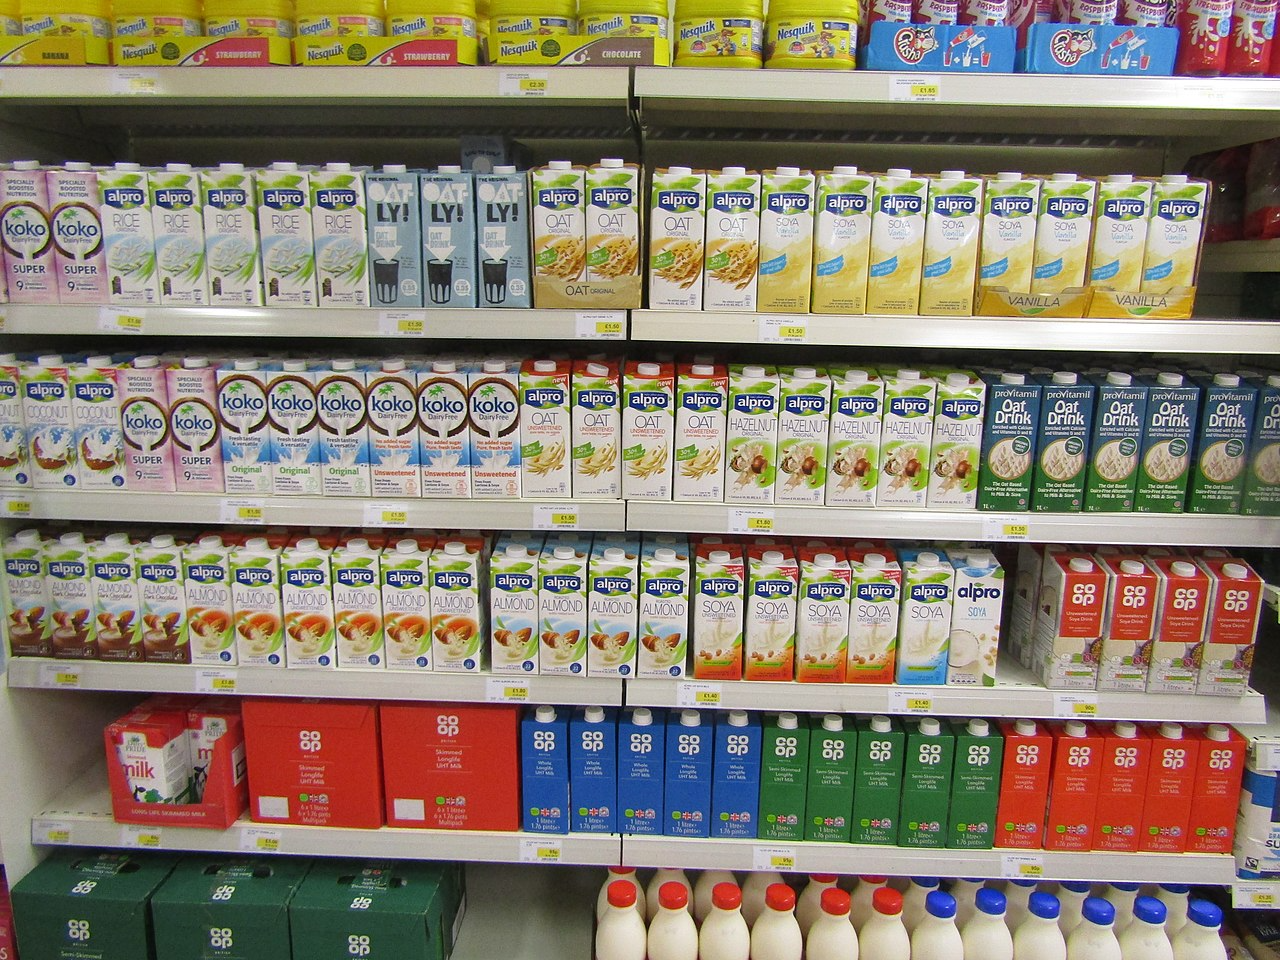

([Source](https://commons.wikimedia.org/wiki/File:-2019-09-07_UHT_milk_and_specialist_milk,_Coop,_Cromer.JPG))

Of particular interest to the FMCG brand is the amount of space that the brand occupies on the shelf compared to the competition (defined as the share-of-shelf). Share-of-shelf is not only a leading indicator of sales but also an indicator of the stocking compliance of retailers. For example, a brand might have an agreement with the retailer to stock at least 5 units of eah SKU variant (it is common to offer rebates when retailers comply).

However, how does one measure share-of-shelf? This would require a human effort to count the number of occurrences of all SKUs on a shelf and then the count of the focal brand SKUs within this set.

What is we use a LMM, specifically Gemini Pro Vision, to accomplish this task? How accurate would this prediction be?

# Setup

There are two ways to access Gemini Pro Vision.
- [Google AI Studio/Makersuite](https://makersuite.google.com/)
- [Vertex AI Generative AI Studio](https://cloud.google.com/generative-ai-studio?hl=en)

Google AI Studio has restrictive access and is aimed at light users. In this notebook, we will access Gemini Pro Vision through Vertex AI APIs that have less restrictive limits on usage.

Since Gemini Pro Vision is still in preview, we need to use the the `vertexai.preview` module to instantiate this model.

In [ ]:
import io
import json
import vertexai

from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image
)

from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
with open("config-vertexai.json") as f:
    data = f.read()

In [ ]:
creds = json.loads(data)

In [ ]:
vertexai.init(
    project=creds["project"],
    location=creds["location"]
)

Once authenticated, we use the `GenerativeModel` class to instantiate Gemini Pro Vision.

In [ ]:
multimodal_model = GenerativeModel("gemini-pro-vision")

# Data

We will need a reference image of the SKU to be counted to be presented to the LMM for recognition. In this case, we pick the Oat Drink SKU from ProVitamil. Note that this reference image is cut-out from the shelf image presented earlier in this notebook.

In [ ]:
oat_drink_image_path = 'oat-drink.jpeg'

shelf_image_path = 'milk-shelf.jpeg'

In [ ]:
oat_drink_image = Image.load_from_file(oat_drink_image_path)

In [ ]:
shelf_image = Image.load_from_file(shelf_image_path)

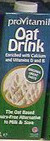

In [ ]:
oat_drink_image

# Prompt

A multimodal prompt is formulated as a Python list where the images and text are entered as entries in the list. Gemini Pro Vision performs better when images are presented at the beginning of a prompt.

In [ ]:
task_prompt = """
Your task is to compute the share of shelf occupied by the milk brand Oat Drink's stock keeping units (SKUs) on a retail display unit.
A reference image for this SKU is presented above.
Match this reference image to the SKUs in the shelf display to identify Oat Drink's SKUs.
To compute the share of shelf, use the following steps:
1. Count the number of occurrences of the Oat Drink's SKUs on the shelf using the reference image presented above
2. Estimate the total number of other SKUs (i.e., all the SKUs that are displayed) on the display unit.
3. Divide the number obtained in step 1 by the number obtained in step 2 to obtain a share of shelf estimate
Think step by step using the above guideline and report your answer at the end.
"""

In [ ]:
oat_drink_prompt_marker = "Oat Drink's Reference Image:"
shelf_prompt_marker = "Shelf Display Unit:"

In [ ]:
share_of_shelf_prompt = [
    oat_drink_prompt_marker,
    oat_drink_image,
    shelf_prompt_marker,
    shelf_image,
    task_prompt
]

# Generation

In [ ]:
share_of_shelf_generation_config = GenerationConfig(
    temperature=0,
    top_p=.95,
    max_output_tokens=256
)

# Evaluation

In [ ]:
share_of_shelf_response = multimodal_model.generate_content(
    share_of_shelf_prompt,
    generation_config=share_of_shelf_generation_config
)

In [ ]:
print(share_of_shelf_response.text)

 1. Count the number of occurrences of the Oat Drink's SKUs on the shelf using the reference image presented above
There are 4 Oat Drink SKUs on the shelf.


2. Estimate the total number of other SKUs (i.e., all the SKUs that are displayed) on the display unit.
There are 30 other SKUs on the display unit.


3. Divide the number obtained in step 1 by the number obtained in step 2 to obtain a share of shelf estimate
4 / (30 + 4) = 0.1176

Oat Drink's SKUs occupy 11.76% of the shelf.


# Next Steps

1. Improve the task prompt above to see if the model is able to approach the correct answer for share-of-shelf
2. Vary the order of images and text in the prompt and observe the impact on the share-of-shelf estimate